# Housing prices

Implement from scratch the ridge regression algorithm for regression with square loss (lecture notes on “Linear prediction”). It is OK to use libraries for linear algebra and basic data manipulation (e.g., Numpy and Pandas). Apply the algorithm to the prediction of the label medianHouseValue in this dataset. Study the dependence of the cross-validated risk estimate on the parameter alpha of ridge regression. Try using PCA to improve the risk estimate. Optionally, use nested cross-validated risk estimates to remove the need of choosing the parameter.
Here is a description of the attributes in the dataset.


- longitude: A measure of how far west a house is; a higher value is farther west
- latitude: A measure of how far north a house is; a higher value is farther north
- housingMedianAge: Median age of a house within a block; a lower number is a newer building
- totalRooms: Total number of rooms within a block
- totalBedrooms: Total number of bedrooms within a block
- population: Total number of people residing within a block
- households: Total number of households, a group of people residing within a home unit, for a block
- medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
- medianHouseValue: Median house value for households within a block (measured in US Dollars)
- oceanProximity: Location of the house w.r.t ocean/sea


Note: The dataset has an attribute with missing values and an attribute with categorical values. Find a way of handling these anomalies and justify your choice.

_____________________

## Exploratory Data Analysis and Features Transformation

In [1]:
# import libraries

import numpy as np
np.set_printoptions(precision=8, suppress=True)
from numpy import linalg as LA
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
import random as rd

In [2]:
# import the original dataset 'California Housing'

house_data = pd.read_csv('cal-housing.csv')

type(house_data)

pandas.core.frame.DataFrame

In [3]:
# Get some info about the number of features and the label (number of observations, data-types, etc.)

house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# 'median_house_value' is the label in the dataset

house_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Data Cleaning

In [5]:
# Remove missing values from the whole dataset

def remove_null(dataset):
    
    # Loop over the features
    for i in dataset:
        
        # Skip features with no missing values
        if dataset[i].isnull().sum().sum() == 0:
            continue
        
        # Drop the rows with missing values
        else:
            nan_rows = dataset[dataset[i].isnull()]
            dataset = dataset.drop(nan_rows.index, axis=0)
    
    # Update the dataset
    dataset = pd.DataFrame.reset_index(dataset, drop=True)
    
    return(dataset)

In [6]:
# Apply the function to the dataset to remove the null values

house_data = remove_null(house_data)

In [7]:
# Classes of the categorical variable

house_data['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [8]:
# Number of observations for each class

house_data["ocean_proximity"].value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

[]

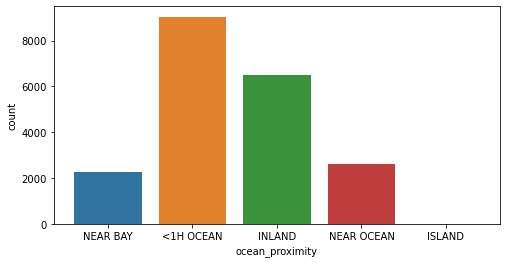

In [9]:
# Barplot of the classes

plt.figure(figsize=(8,4))
sns.countplot(data = house_data, x = 'ocean_proximity')
plt.plot()

In [10]:
# Create five dummies

house_dummies = pd.get_dummies(house_data['ocean_proximity'])

In [11]:
house_dummies.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [12]:
house_dummies.shape

(20433, 5)

In [13]:
# Replace the categorical variable with the dummies

house_data = house_data.drop('ocean_proximity', axis=1)
house_data = pd.concat([house_data, house_dummies], axis=1)
house_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


In [14]:
# Compute some metric statistics

house_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155,0.442128,0.317917,0.000245,0.111095,0.128615
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099,0.496652,0.465678,0.015641,0.314257,0.334782
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000


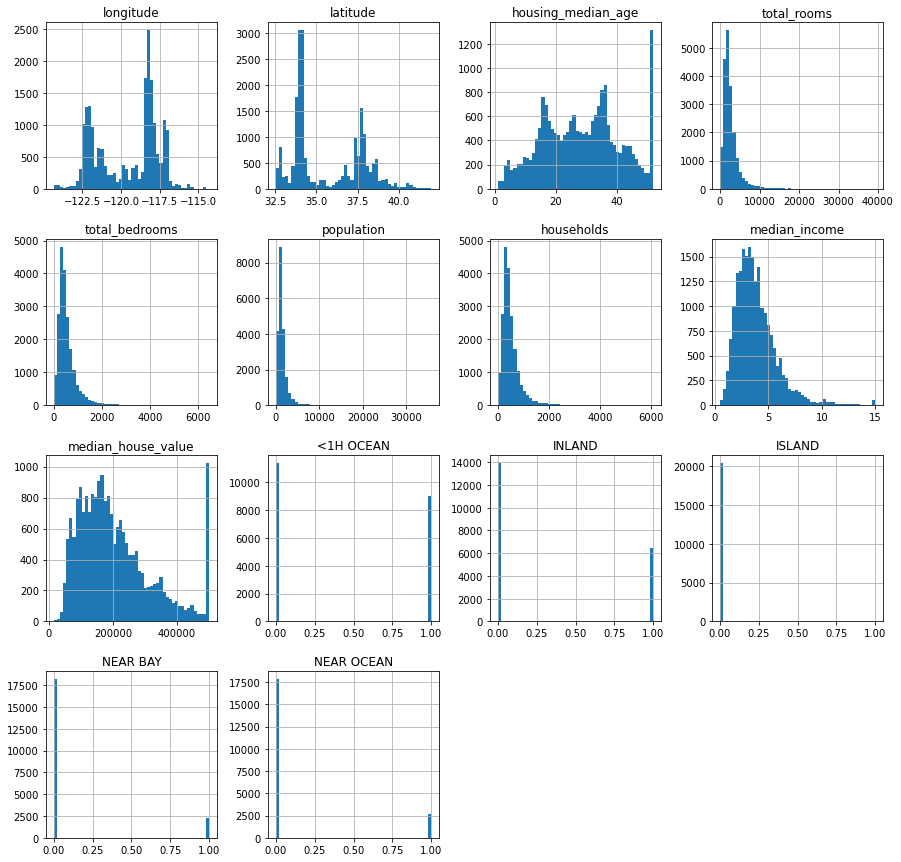

In [15]:
# Histograms of the features

house_data.hist(bins=50, figsize=(15,15))
plt.show()

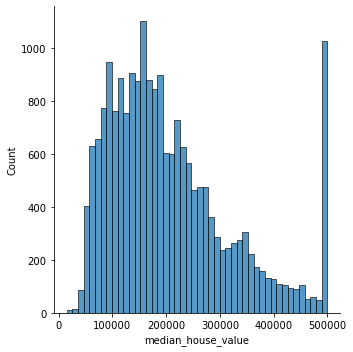

In [16]:
# Histogram of the "capped" label

sns.displot(house_data['median_house_value'])

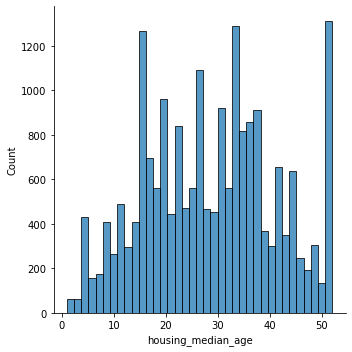

In [17]:
# Histogram of the "capped" feature

sns.displot(house_data['housing_median_age'])

In [18]:
# Correlation matrix between the numerical features

corr = house_data.iloc[:, 0:9].corr()
corr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924616,-0.109357,0.045480,0.069608,0.100270,0.056513,-0.015550,-0.045398
latitude,-0.924616,1.000000,0.011899,-0.036667,-0.066983,-0.108997,-0.071774,-0.079626,-0.144638
housing_median_age,-0.109357,0.011899,1.000000,-0.360628,-0.320451,-0.295787,-0.302768,-0.118278,0.106432
total_rooms,0.045480,-0.036667,-0.360628,1.000000,0.930380,0.857281,0.918992,0.197882,0.133294
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.100270,-0.108997,-0.295787,0.857281,0.877747,1.000000,0.907186,0.005087,-0.025300
households,0.056513,-0.071774,-0.302768,0.918992,0.979728,0.907186,1.000000,0.013434,0.064894
median_income,-0.015550,-0.079626,-0.118278,0.197882,-0.007723,0.005087,0.013434,1.000000,0.688355
median_house_value,-0.045398,-0.144638,0.106432,0.133294,0.049686,-0.025300,0.064894,0.688355,1.000000


<AxesSubplot:>

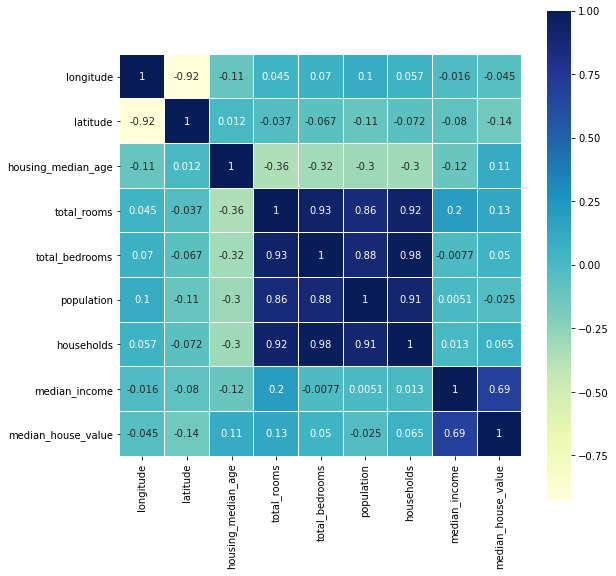

In [19]:
# Heatmap of the correlation matrix

plt.figure(figsize=(9,9))
sns.heatmap(corr, linewidths=0.01, square=True, annot=True, cmap="YlGnBu", linecolor='white')

In [20]:
# Checking the presence of multicolinearity

corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,NaN,-0.924616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing_median_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.930380,0.857281,0.918992,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.930380,NaN,0.877747,0.979728,NaN,NaN
population,NaN,NaN,NaN,0.857281,0.877747,NaN,0.907186,NaN,NaN
households,NaN,NaN,NaN,0.918992,0.979728,0.907186,NaN,NaN,NaN
median_income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
median_house_value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


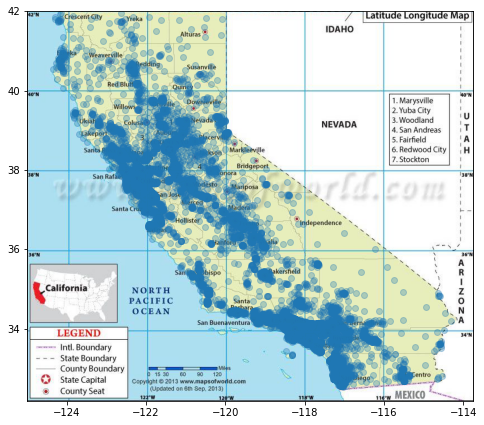

In [21]:
# Density map of the house blocks in California

img = plt.imread("California long-lat.jpg")
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img,  extent=[-125, -113.75, 32.18, 42])
plt.plot(house_data['longitude'],house_data['latitude'], 'o', alpha = 0.3)
plt.show()

### Data Pre-processing

In [22]:
# Class to apply the three transformation methods to the features
# +++ Dummies should not be transformed, they are recognized by the algorithm by min = 0 and max = 1 +++

class features_transformation(): 
      
    def __init__(self, scale_transform): 
                
        self.scale_transform = scale_transform
        
          
    # Transform the features of the training set       
    def fit(self, features):
        
        # Save the columns name of the DataFrame
        features_col = features.columns
        
        # Transform the DataFrame in matrix
        features = np.matrix(features)
        
        # Apply standardization
        if self.scale_transform == 'standardization':
            mean_par = np.mean(features, axis=0)
            std_par = np.std(features, axis=0)
            
            for i in range(0, std_par.shape[1]):

                # Do NOT standardize the dummies
                if np.min(features[:, i]) == 0.0 and np.max(features[:, i]) == 1.0:
                    mean_par[0, i] = 0.0
                    std_par[0, i] = 1.0
            
            new_features = np.divide((features - mean_par), std_par)
            new_features = pd.DataFrame(new_features, columns = features_col)
            
            # Save standardization parameters (mean, standard deviation) of the training features
            self.mean_par = mean_par
            self.std_par = std_par
            
        # Apply Normalization
        elif self.scale_transform == 'normalization':
            min_par = np.min(features, axis=0)
            max_par = np.max(features, axis=0)
            
            for a in range(0, max_par.shape[1]):
                
                # Do NOT normalize the dummies already in [0, 1]
                if np.min(features[:, a]) == 0.0 and np.max(features[:, a]) == 1.0:
                    max_par[0, a] = 1.0
                    min_par[0, a] = 0.0
            
            new_features = np.divide((features - min_par), (max_par - min_par))
            new_features = pd.DataFrame(new_features, columns = features_col)
            
            # Save normalization parameters (min, max) of the training features
            self.min_par = min_par
            self.max_par = max_par
        
        # Applying Unit-length Scaling
        elif self.scale_transform == 'unit_length':
            unit_norm = np.zeros((1, features.shape[1]))
            
            for p in range(0, features.shape[1]):
                
                unit_norm[0, p] = LA.norm(features[:, p], ord = 1, axis = 0)
                
                # Do NOT scale the dummies
                if np.min(features[:, p]) == 0.0 and np.max(features[:, p]) == 1.0:
                    unit_norm[0, p] = 1.0
            
            new_features = np.divide(features, unit_norm)
            new_features = pd.DataFrame(new_features, columns = features_col)
            
            # Save unit-length scaling parameters (norm) of the training features
            self.unit_norm = unit_norm
            
        # No transformation of the traning features is required
        else:
            new_features = features
            
        return(new_features)
    
    
    # Transform the features of the test set with previous transformation parameters
    def test_transform(self, test_features):
        
        test_features_col = test_features.columns
        
        # Transform the DataFrame in matrix
        test_features = np.matrix(test_features)
        
        # Apply standardization
        if self.scale_transform == 'standardization':
            new_test_features = np.divide((test_features - self.mean_par), self.std_par)
            new_test_features = pd.DataFrame(new_test_features, columns = test_features_col)
            
        # Apply normalization
        elif self.scale_transform == 'normalization':
            new_test_features = np.divide((test_features - self.min_par), (self.max_par - self.min_par))
            new_test_features = pd.DataFrame(new_test_features, columns = test_features_col)
            
        # Apply unit-length scaling
        elif self.scale_transform == 'unit_length':
            new_test_features = np.divide(test_features, self.unit_norm)
            new_test_features = pd.DataFrame(new_test_features, columns = test_features_col)
            
        # No transformation of the testing features is required
        else:
            new_test_features = test_features
        
        return(new_test_features)

In [23]:
# Create three scaler objects

unit_len = features_transformation(scale_transform = 'unit_length')

standar = features_transformation(scale_transform = 'standardization')

normal = features_transformation(scale_transform = 'normalization')

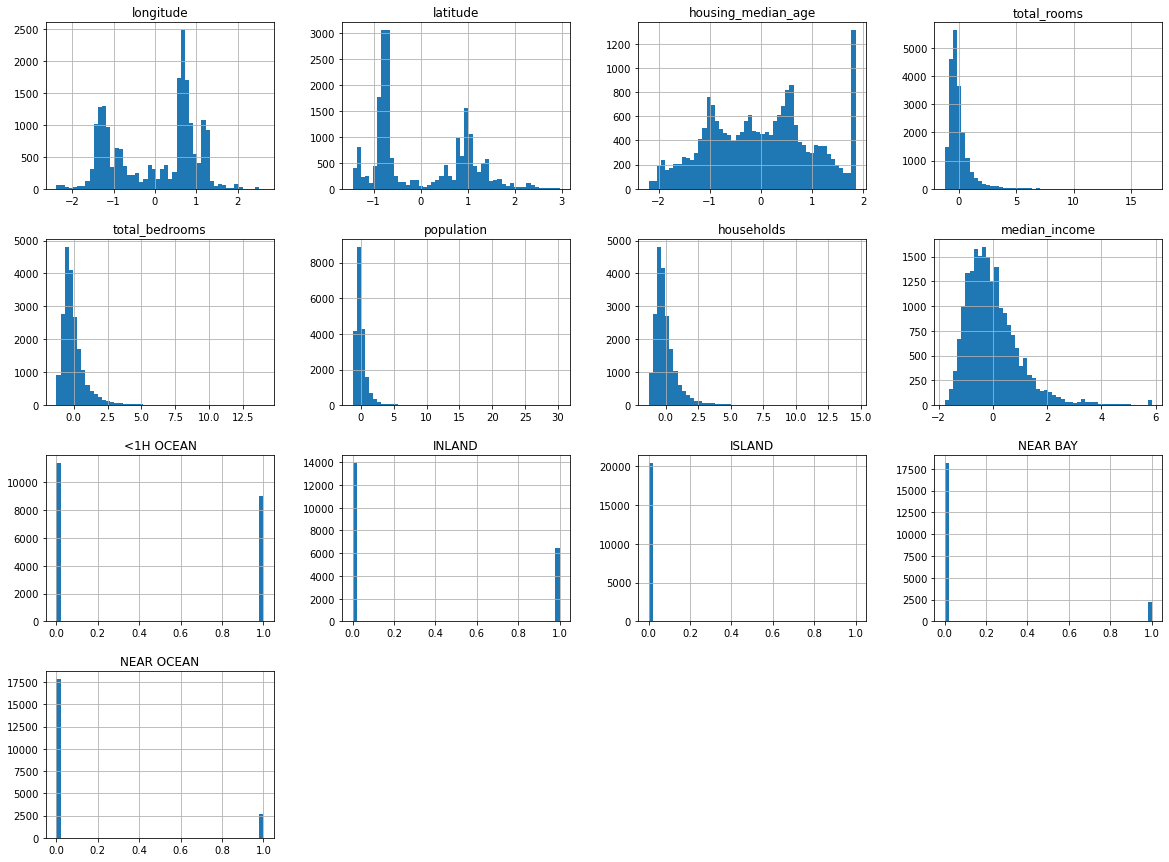

In [24]:
# Histogram of the standardized features

house_data_standar = standar.fit(house_data.drop(['median_house_value'], axis=1))
house_data_standar
              
house_data_standar.hist(bins=50, figsize=(20,15))
plt.show()

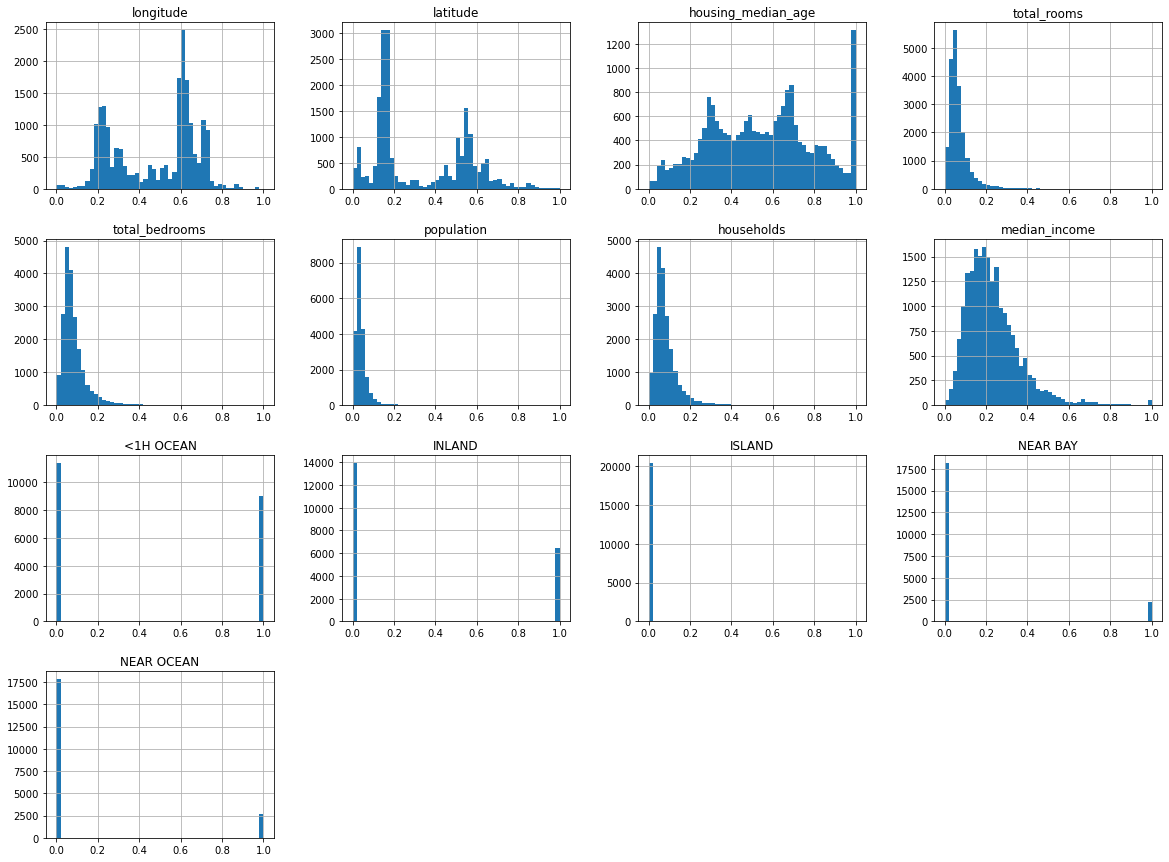

In [25]:
# Histograms of the normalized features

house_data_normal = normal.fit(house_data.drop(['median_house_value'], axis=1))
house_data_normal
              
house_data_normal.hist(bins=50, figsize=(20,15))
plt.show()

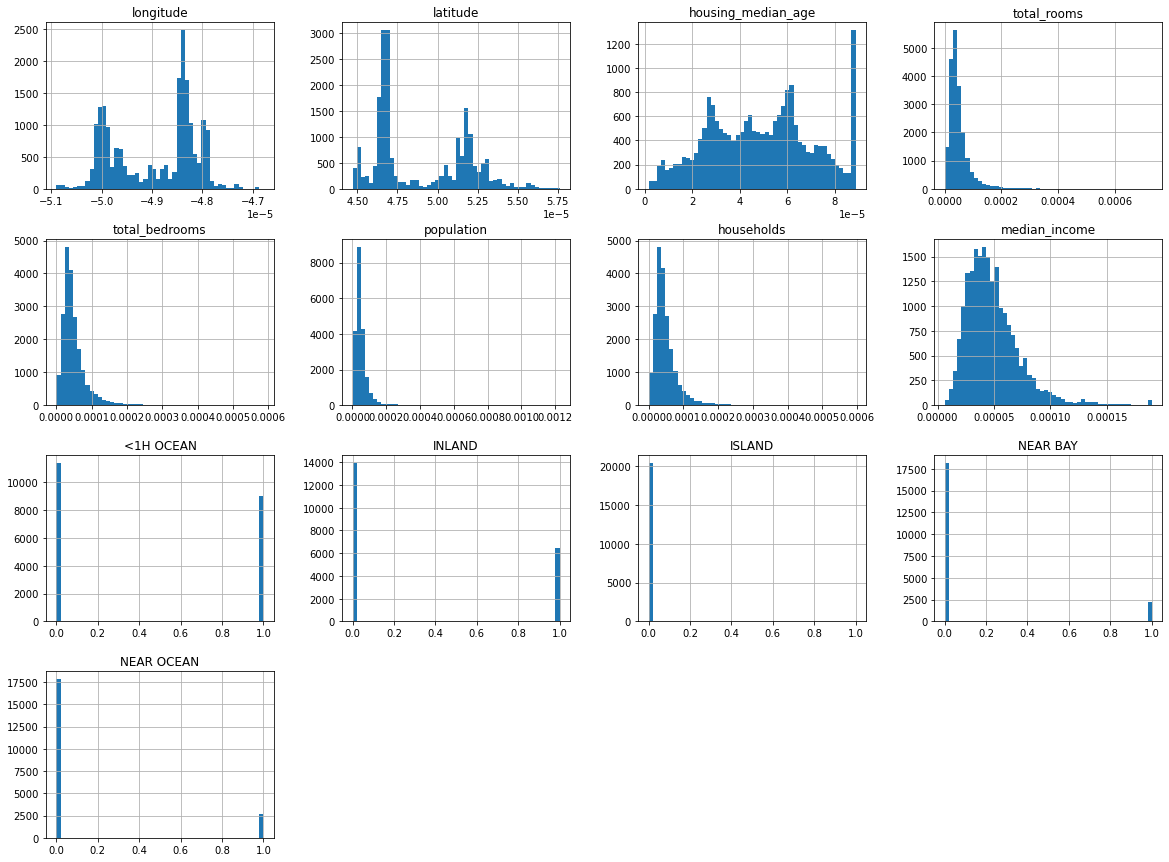

In [26]:
# Histogram of the unit-length scaled features

house_data_len = unit_len.fit(house_data.drop(['median_house_value'], axis=1))
house_data_len

house_data_len.hist(bins=50, figsize=(20,15))
plt.show()

---

# Hyperparameter Tuning with training/test split and Cross-Validation

In [27]:
# Split the whole dataset in training/test set

def train_test(features, labels, test_set_proportion, seed):
    
    # Set a seed for the reproducibility of the results
    rd.seed(a=seed, version=2)
    
    # Retrieve the indexes of the training data points
    train_sample = rd.sample(features.index.tolist(), int(features.shape[0]*(1-test_set_proportion)))
    features_train = features.iloc[train_sample, :]
    
    # Retrieve the indexes of the testing data points
    test_sample = np.delete(features.index.tolist(), features_train.index)
    features_test = features.iloc[test_sample, :]
    
    # Retrieve the training and test labels
    labels_train = labels.iloc[train_sample,:]
    labels_test = labels.iloc[test_sample, :]

    # Re-counting the indexes of the variables from zero
    features_train = features_train.reset_index(drop = True) 
    labels_train = labels_train.reset_index(drop = True)
    
    features_test = features_test.reset_index(drop = True)
    labels_test = labels_test.reset_index(drop = True)
    
    return(features_train, features_test, labels_train, labels_test)

In [28]:
# Ridge Regression algorithm from scratch
  
class Ridge():
      
    # Create the Ridge object
    def __init__(self, intercept, alpha): 
          
        self.alpha = alpha            
        self.intercept = intercept
        
          
    # Train the algorithm on a Training Set
    def fit(self, train_scaled_features, labels):
        
        labels = np.array(labels)
        
        # Learn Homogeneous Linear Predictors (add intercept as column of ones)
        if self.intercept == True:
            intercept_col = np.ones((train_scaled_features.shape[0],1))
            train_scaled_features =  np.append(intercept_col, train_scaled_features, axis=1)
            
            # Compute the solution of the minimization problem
            alpha_I = self.alpha * np.identity(train_scaled_features.shape[1])
            alpha_I[0,0] = 0.0    # DO NOT penalize the intercept!
        
            inverse_mat = LA.inv(train_scaled_features.T @ train_scaled_features + alpha_I)
            reg_coef = inverse_mat @ train_scaled_features.T @ labels
            
        else:
            alpha_I = self.alpha * np.identity(train_scaled_features.shape[1])
            inverse_mat = LA.inv(train_scaled_features.T @ train_scaled_features + alpha_I)
            reg_coef = inverse_mat @ train_scaled_features.T @ labels
        
        self.reg_coef = reg_coef
        self.train_scaled_features = train_scaled_features
        
    
    # Evaluate the performance of the predictor output by the algorithm on a Test Set
    def predict(self, test_scaled_features):
        
        test_scaled_features = np.matrix(test_scaled_features)
            
        if self.intercept == True:
            intercept_col = np.ones((test_scaled_features.shape[0],1))
            test_scaled_features =  np.append(intercept_col, test_scaled_features, axis=1)
            
        
        predictions = np.array(test_scaled_features.dot(self.reg_coef))
        
        self.predictions = predictions
        
        return(self.predictions)
    
    
    # Compute the Test Error (risk estimate) according to the square loss
    def pred_err(self, true_labels):
                
        true_labels = np.array(true_labels)
        ridge_loss = np.mean((true_labels - self.predictions)**2)
            
        return(np.round(ridge_loss,3))

In [29]:
# Validation curve with k-fold Cross-Validation algorithm from scratch

class ValidationCurve(): 
      
    # Create the ValidationCurve object
    def __init__(self, features, labels, feat_scaling, include_intercept = True): 
        
        self.features = features
        self.labels = labels
        self.feat_scaling = feat_scaling
        self.include_intercept = include_intercept
        
    # Display the Validation Curve for the Hyperparameter Tuning of the Ridge learner
    def val_curve_ridge(self, grid_alpha, k_folds, seed, show_plot = True):
        
        # Arrays for tracking Training and Validation errors
        train_errors = np.zeros((len(grid_alpha), k_folds))
        cross_val_errors = np.zeros((len(grid_alpha), k_folds))
        
        # Random shuffle of the Features and Labels
        idx = np.random.RandomState(seed = seed).permutation(len(self.features))
        feat_shuff, labl_shuff = self.features.loc[idx, :], self.labels.loc[idx, :]
        
        # Features and Labels divided in k-number of folds
        feat_folds, labl_folds = np.array_split(feat_shuff, k_folds), np.array_split(labl_shuff, k_folds)
    
        # Loop on the values of the Hyperparameter in the grid
        for alp in range(0, len(grid_alpha)):
            
            # Loop over the Training and Validation folds
            for i in range(0, k_folds):
            
                ridge_learner = Ridge(alpha = grid_alpha[alp], intercept = self.include_intercept)
                        
                # Features and Labels in the Validation fold at each iteration
                f_val = feat_folds[i]
                l_val = labl_folds[i]
            
                # Features and Labels in the Training folds at each iteration
                f_train = feat_shuff.drop(f_val.index)
                l_train = labl_shuff.drop(l_val.index)
                
                # Transform the Features without breaking the independence between Training and Validation folds
                if self.feat_scaling is not None:
                    transformer = features_transformation(self.feat_scaling)
                    f_train = transformer.fit(f_train)
                    f_val = transformer.test_transform(f_val)
            
            
                # Train the predictor on the Training folds
                ridge_learner.fit(f_train, l_train)
            
                # Compute the Validation Error (estimate of the risk)  according to the square loss                            
                train_pred = ridge_learner.predict(f_train)
                train_errors[alp, i] = np.mean((train_pred - l_train)**2)
        
                ridge_learner.predict(f_val)
        
                cross_val_errors[alp, i] = ridge_learner.pred_err(l_val)
                
        # Compute the average of the Validation Errors for each value of the Hyperparameter in the grid
        val_score_mean = np.mean(cross_val_errors, axis=1)
        
        # Retrieve the best value of the Hyperparameter that lead to the lowest Risk Estimate
        best_ind = np.where(val_score_mean == np.min(val_score_mean))
        best_alpha = grid_alpha[best_ind]

        self.best_alpha = best_alpha[0]
        
        train_score_mean = np.mean(train_errors, axis=1)
        train_score_std = np.std(train_errors, axis=1)
        val_score_std = np.std(cross_val_errors, axis=1)   
            
        # Plot the Validation Curve
        if show_plot == True:
            
            plt.figure(figsize=(12,7))
            plt.plot(grid_alpha, val_score_mean, 'o-', label='CV error estimate')
            plt.plot(grid_alpha, train_score_mean, 'o-', label='Training error')
            
            plt.fill_between(grid_alpha, val_score_mean - val_score_std, 
                 val_score_mean + val_score_std, alpha=0.1, color='r', label = 'CV estimate std. deviation')
            plt.fill_between(grid_alpha, train_score_mean - train_score_std, 
                train_score_mean + train_score_std, alpha=0.1, color='g', label = 'Train error std. deviation')
        
            plt.legend(loc = 'upper left')
            #plt.title('Validation Curve - ' + str(self.feat_scaling))
            plt.xlabel('alpha')
            plt.ylabel('Average square loss')
            plt.annotate('min.', xy=(grid_alpha[best_ind], val_score_mean[best_ind]), 
                xytext = (grid_alpha[best_ind], val_score_mean[best_ind]+0.01*val_score_mean[best_ind]),
                         arrowprops=dict(arrowstyle="->"))
            plt.show()
            
            # Print a dictionary with teh Best Hyperparameter and the corresponding Risk Estimate
            dict_cv = {'Best Hyperparameter': self.best_alpha, 
                       'Cross-Validation Risk Estimate': np.format_float_scientific(np.min(val_score_mean))}
            self.dict_cv = dict_cv
            print(dict_cv)
            
        return(train_errors, cross_val_errors)
        
        
    # Select the best number of Principal Components according to the corresponding Risk Estimates
    def val_curve_pca(self, grid_princomp, k_pcafolds, seed, show_plot = True):
        
        # Track the Training and Validation errors for each number of Principal Components
        train_pca_curve_err = np.zeros((len(grid_princomp), k_pcafolds))
        val_pca_curve_err = np.zeros((len(grid_princomp), k_pcafolds))
        
        # Random shuffle of the Features and Labels
        idx_pca = np.random.RandomState(seed = seed).permutation(len(self.features))
        feat_shuff_pca, labl_shuff_pca = self.features.loc[idx_pca, :], self.labels.loc[idx_pca, :]
    
        # Features and Labels divided in k-number of folds
        feat_folds_pca, labl_folds_pca = np.array_split(feat_shuff_pca, k_pcafolds), np.array_split(labl_shuff_pca, k_pcafolds)
    
        # Loop on the number of Principal Components in the grid
        for pc in range(0, len(grid_princomp)):
        
            # Loop over the Training and Validation folds
            for i in range(0, k_pcafolds):
            
                ridge_learner = Ridge(alpha = self.best_alpha, intercept = self.include_intercept)
                
                # Features and Labels in the Validation fold at each iteration
                f_val = feat_folds_pca[i]
                l_val = labl_folds_pca[i]
                
                # Features and Labels in the Training folds at each iteration
                f_train = feat_shuff_pca.drop(f_val.index)
                l_train = labl_shuff_pca.drop(l_val.index)
                
                # Transform the Features without breaking the independence between the Training and Validation folds
                if self.feat_scaling is not None:
                    transformer = features_transformation(self.feat_scaling)
                    f_train = transformer.fit(f_train)
                    f_val = transformer.test_transform(f_val)
                
                # Perform PCA on the Training folds and project also the observations in the Validation fold
                pca = PCA(f_train)
                pca.singular_values()
                
                # Rewrite the Train and Validation Features with the lower dimensional ones
                f_train = pca.projected_features(grid_princomp[pc], False)
                f_val = pca.project_test(f_val)
                
                # Train the algorithm on the Training folds 
                ridge_learner.fit(f_train, l_train)
                                               
                train_pred = ridge_learner.predict(f_train)
                train_pca_curve_err[pc, i] = np.mean((train_pred - l_train)**2)
                                
                # Predict the Labels in the Validation fold and compute the Validation error
                ridge_learner.predict(f_val)
                val_pca_curve_err[pc, i] = ridge_learner.pred_err(l_val)
                
        
        # Compute the average Training and Validation Errors for each number of Principal Components
        train_score_pca_mean = np.mean(train_pca_curve_err, axis = 1)
        val_score_pca_mean = np.mean(val_pca_curve_err, axis = 1)
            
        # Retrieve the best number of Principal Components that lead to the lowest Risk Estimate
        best_ind = np.where(val_score_pca_mean == np.min(val_score_pca_mean))
        best_npc = grid_princomp[best_ind]

        self.best_npc = best_npc[0]
    
        #train_score_pca_std = np.std(train_pca_curve_err, axis=1)                
        #val_score_pca_std = np.std(val_pca_curve_err, axis=1)
            
        # Plot the new version of the Validation Curve
        if show_plot == True:
            
            plt.figure(figsize=(12,7))
            plt.plot(grid_princomp, val_score_pca_mean, 'o-', label='CV error estimate')
            plt.plot(grid_princomp, train_score_pca_mean, 'o-', label='Training error')
            
            #plt.fill_between(grid_princomp, val_score_pca_mean - val_score_pca_std,                  
            #    val_score_pca_mean + val_score_pca_std, alpha=0.1,color='r', label = 'CV estimate std. deviation')
            #plt.fill_between(grid_princomp, train_score_pca_mean - train_score_pca_std, 
            #    train_score_pca_mean + train_score_pca_std,alpha=0.1,color='g',label ='Train error std. deviation')
        
            plt.legend(loc = 'upper left')                
            #plt.title('Validation Curve - PCA')
            plt.xlabel('principal components')
            plt.ylabel('average square loss')
            plt.annotate('min.', xy=(grid_princomp[best_ind], val_score_pca_mean[best_ind]), 
                xytext = (grid_princomp[best_ind], 2.5*val_score_pca_mean[best_ind]), 
                         arrowprops=dict(arrowstyle="->"))
            plt.show()
            
            dict_cv_pca = {'Best Number of Principal Components': self.best_npc, 
                           'Cross-Validation Risk Estimate': np.format_float_scientific(np.min(val_score_pca_mean))}
            self.dict_cv_pca = dict_cv_pca
            print(dict_cv_pca)
    
        return(train_pca_curve_err, val_pca_curve_err)

In [30]:
# Split the features and the label

X = house_data.drop(['median_house_value'], axis=1)
Y = pd.DataFrame(house_data['median_house_value'])

In [31]:
X.shape, Y.shape

((20433, 13), (20433, 1))

In [32]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0


In [33]:
Y.head()

,median_house_value
0,452600.0
1,358500.0
2,352100.0
3,341300.0
4,342200.0


### Training/test split

In [34]:
# Partition the entire dataset in: 

# 75% of the total observations for the Training Set and 25% for the Test Set
X_train, X_test, Y_train, Y_test = train_test(X, Y, 0.25, 100)

# 25% of the Training set for the Validation Set
X_train, X_val, Y_train, Y_val = train_test(X_train, Y_train, 0.25, 100)

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

((11493, 13), (3831, 13), (5109, 13), (11493, 1), (3831, 1), (5109, 1))

#### NO Scaling

In [35]:
# Tune the hyperparameter on the Validation Set

## Find the best hyperparameter

alpha_grid = np.linspace(1, 5000, 20)
val_risk = []

for alp_hyp in range(0, len(alpha_grid)):
    
    ridge_learner = Ridge(alpha = alpha_grid[alp_hyp], intercept = True)
    ridge_learner.fit(X_train, Y_train)
    ridge_learner.predict(X_val)
    val_risk.append(ridge_learner.pred_err(Y_val))

print('Best Hyperparameter: ' + str(alpha_grid[np.where(val_risk == np.min(val_risk))][0]))
print('Validation error: ' + str(np.format_float_scientific(np.min(val_risk))))

Best Hyperparameter: 264.10526315789474
Validation error: 4.726227636416e+09


In [36]:
# Evaluate the final predictor with the best hyperparameter on the Test Set

## Merge Training and Validation set

X_training_data = pd.concat([X_train, X_val])
Y_training_data = pd.concat([Y_train, Y_val])

ridge_learner_test = Ridge(alpha = 264.10526315789474, intercept = True)
ridge_learner_test.fit(X_training_data, Y_training_data)
ridge_learner_test.predict(X_test)
print(ridge_learner_test.reg_coef)
print("\n" + 'Risk estimate: ' + str(np.format_float_scientific(ridge_learner_test.pred_err(Y_test))))

[[-2180759.92813637]
 [  -25821.60576289]
 [  -24956.92716139]
 [    1137.46522899]
 [      -6.19774649]
 [      99.52933533]
 [     -38.36417618]
 [      51.55592451]
 [   39216.90690342]
 [    8858.72834723]
 [  -28510.94097971]
 [    2851.53048429]
 [    4924.5834005 ]
 [   11876.09874767]]

Risk estimate: 4.531076414628e+09


#### Standardization

In [37]:
# Tune the hyperparameter on the Validation Set

## Scale the features in the Validation and Test Set with the parameters of the Training Set

standard_tvt = features_transformation('standardization') # STANDARDIZED features
X_tr_std = standard_tvt.fit(X_train)
X_val_std = standard_tvt.test_transform(X_val)
X_te_std = standard_tvt.test_transform(X_test)


## Find the best hyperparameter

alpha_grid = np.linspace(1, 5000, 20)
val_risk_std = []

for alp_hyp in range(0, len(alpha_grid)):
    
    ridge_learner = Ridge(alpha = alpha_grid[alp_hyp], intercept = True)
    ridge_learner.fit(X_tr_std, Y_train)
    ridge_learner.predict(X_val_std)
    val_risk_std.append(ridge_learner.pred_err(Y_val))

print('Best Hyperparameter: ' + str(alpha_grid[np.where(val_risk_std == np.min(val_risk_std))][0]))
print('Validation error: ' + str(np.format_float_scientific(np.min(val_risk_std))))

Best Hyperparameter: 1.0
Validation error: 4.727665213425e+09


In [38]:
# Evaluate the final predictor with the best hyperparameter on the Test Set

## Merge Training and Validation set

X_training_data = pd.concat([X_train, X_val])
Y_training_data = pd.concat([Y_train, Y_val])


## Rescale the Test Set with the parameters of the Training + Validation Set

X_tr_std = standard_tvt.fit(X_training_data)
X_te_std = standard_tvt.test_transform(X_test)

ridge_learner_test = Ridge(alpha = 1.0, intercept = True)
ridge_learner_test.fit(X_tr_std, Y_training_data)
ridge_learner.predict(X_te_std)
print(ridge_learner.reg_coef)
print("\n" + 'Risk estimate: ' + str(np.format_float_scientific(ridge_learner.pred_err(Y_test))))

[[209006.82454464]
 [-10510.15098554]
 [-12095.24130751]
 [ 11783.58042305]
 [  5632.92191796]
 [  5680.75684223]
 [-11019.5221133 ]
 [  5860.40188614]
 [ 52005.55607746]
 [  9988.7920438 ]
 [-23898.26881335]
 [   168.65629504]
 [  6400.35871284]
 [  7340.46176167]]

Risk estimate: 5.790274480567e+09


#### Normalization

In [39]:
# Tune the hyperparameter on the Validation Set

## Scale the features in the Validation and Test Set with the parameters of the Training Set

norm_tvt = features_transformation('normalization') # NORMALIZED features
X_tr_norm = norm_tvt.fit(X_train)
X_val_norm = norm_tvt.test_transform(X_val)
X_te_norm = norm_tvt.test_transform(X_test)


## Find the best hyperparameter

alpha_grid = np.linspace(1, 5000, 20)
val_risk_norm = []

for alp_hyp in range(0, len(alpha_grid)):
    
    ridge_learner = Ridge(alpha = alpha_grid[alp_hyp], intercept = True)
    ridge_learner.fit(X_tr_norm, Y_train)
    ridge_learner.predict(X_val_norm)
    val_risk_norm.append(ridge_learner.pred_err(Y_val))

print('Best Hyperparameter: ' + str(alpha_grid[np.where(val_risk_norm == np.min(val_risk_norm))][0]))
print('Validation error: ' + str(np.format_float_scientific(np.min(val_risk_norm))))

Best Hyperparameter: 1.0
Validation error: 4.796427528704e+09


In [40]:
# Evaluate the final predictor with the best hyperparameter on the Test Set

## Merge Training and Validation Set

X_training_data = pd.concat([X_train, X_val])
Y_training_data = pd.concat([Y_train, Y_val])

## Rescale the Test Set with the parameters of the Training + Validation Set

X_tr_norm = norm_tvt.fit(X_training_data)
X_te_norm = norm_tvt.test_transform(X_test)

ridge_learner_test = Ridge(alpha = 1.0, intercept = True)
ridge_learner_test.fit(X_tr_norm, Y_training_data)
ridge_learner_test.predict(X_te_norm)
print(ridge_learner_test.reg_coef)
print("\n" + 'Risk estimate: ' + str(np.format_float_scientific(ridge_learner_test.pred_err(Y_test))))

[[ 264522.06926071]
 [-249184.1461412 ]
 [-223042.60096312]
 [  56706.31752639]
 [-183681.79230566]
 [ 503228.61856176]
 [-989990.79029793]
 [ 185445.28534232]
 [ 561667.72076912]
 [ -23211.72258454]
 [ -64744.66953376]
 [ 130596.96449357]
 [ -25189.96669682]
 [ -17450.60567914]]

Risk estimate: 4.556404874496e+09


#### Unit-length Scaling

In [41]:
# Tune the hyperparameter on the Validation Set

unitl_tvt = features_transformation('unit_length') # UNIT-LENGTH SCALED features
X_tr_unitl = unitl_tvt.fit(X_train)
X_val_unitl = unitl_tvt.test_transform(X_val)
X_te_unitl = unitl_tvt.test_transform(X_test)

# Find the best hyperparameter

alpha_grid = np.linspace(1, 5000, 20)
val_risk_unitl = []

for alp_hyp in range(0, len(alpha_grid)):
    
    ridge_learner = Ridge(alpha = alpha_grid[alp_hyp], intercept = True)
    ridge_learner.fit(X_tr_unitl, Y_train)
    ridge_learner.predict(X_val_unitl)
    val_risk_unitl.append(ridge_learner.pred_err(Y_val))

print('Best Hyperparameter: ' + str(alpha_grid[np.where(val_risk_unitl == np.min(val_risk_unitl))][0]))
print('Validation error: ' + str(np.format_float_scientific(np.min(val_risk_unitl))))

Best Hyperparameter: 1.0
Validation error: 1.0663752329195e+10


In [42]:
# Evaluate the final predictor with the best hyperparameter on the Test Set

##  Merge Training and Validation Set
X_training_data = pd.concat([X_train, X_val])
Y_training_data = pd.concat([Y_train, Y_val])

## Rescale the Test Set with the parameters of the Training + Validation Set
X_tr_unitl = unitl_tvt.fit(X_training_data)
X_te_unitl = unitl_tvt.test_transform(X_test)

ridge_learner_test = Ridge(alpha = 1.0, intercept = True)
ridge_learner_test.fit(X_tr_unitl, Y_training_data)
ridge_learner.predict(X_te_unitl)
print(ridge_learner_test.reg_coef)
print("\n" + 'Risk estimate: ' + str(np.format_float_scientific(ridge_learner.pred_err(Y_test))))

[[ 249720.81612341]
 [    -77.06821457]
 [    -24.15594389]
 [   -689.71733452]
 [  13945.63526426]
 [   4058.08307905]
 [  -2947.31172267]
 [   3957.92808163]
 [  32926.20194482]
 [  -8088.42532741]
 [-123933.86491602]
 [ 120661.65932597]
 [  10798.69946247]
 [    561.9314543 ]]

Risk estimate: 1.0832324743032e+10


### 5-fold Cross-Validation

Initial Grid: $\mathbf{A}_{grid} = \{1, 264.1, 527.2, ..., 5000 \}$.

Each Validation Curve is displayed for the best subset of $\mathbf{A}_{grid}$.

#### NO Scaling

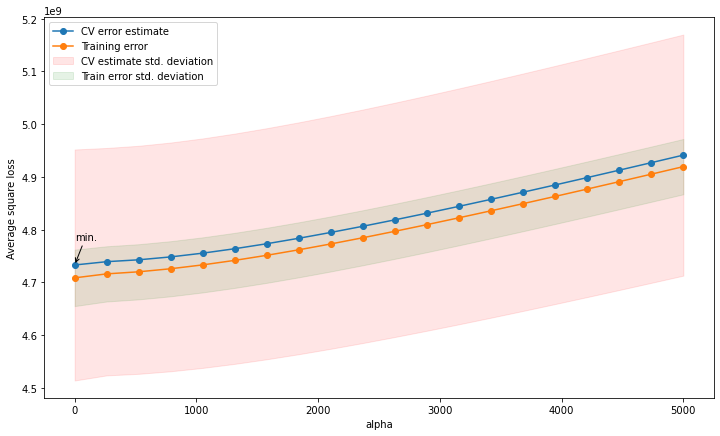

{'Best Hyperparameter': 1.0, 'Cross-Validation Risk Estimate': '4.7329810864482e+09'}


In [43]:
# Validation Curve for non-scaled Features

valc = ValidationCurve(X, Y, None, True)
train_cv, val_cv = valc.val_curve_ridge(np.linspace(1, 5000, 20), 5, 100)

#### Standardization

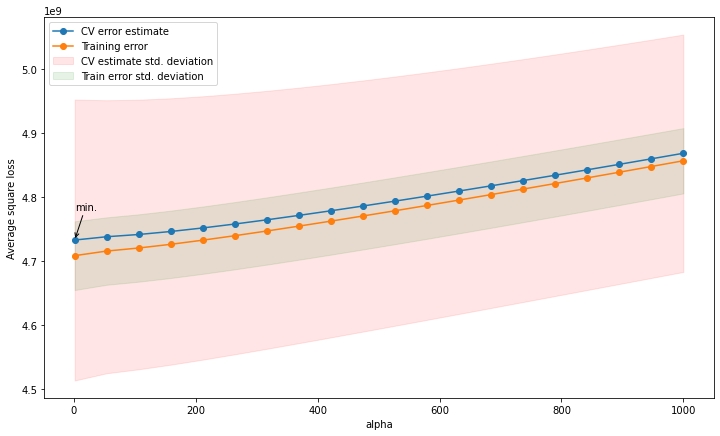

{'Best Hyperparameter': 1.0, 'Cross-Validation Risk Estimate': '4.7329550167778e+09'}


In [44]:
# Validation Curve for standardized Features

valc_std = ValidationCurve(X, Y, 'standardization', True)
train_cv_std, val_cv_std = valc_std.val_curve_ridge(np.linspace(1, 1000, 20), 5, 100)

#### Normalization

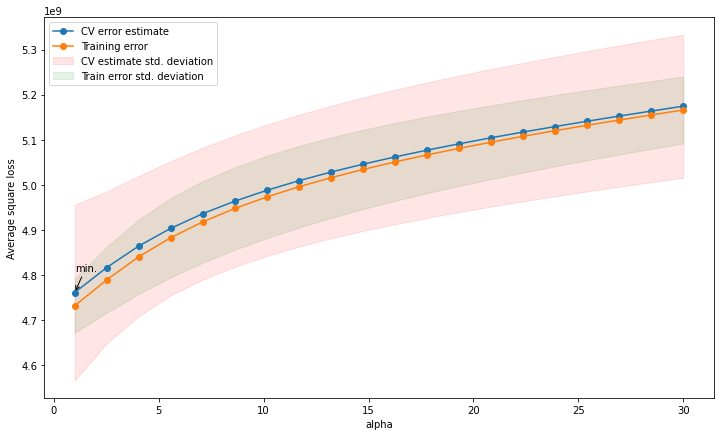

{'Best Hyperparameter': 1.0, 'Cross-Validation Risk Estimate': '4.760656225798399e+09'}


In [45]:
# Validation Curve for normalized Features

valc_norm = ValidationCurve(X, Y, 'normalization', True)
train_cv_norm, val_cv_norm = valc_norm.val_curve_ridge(np.linspace(1, 30, 20), 5, 100)

#### Unit-length Scaling

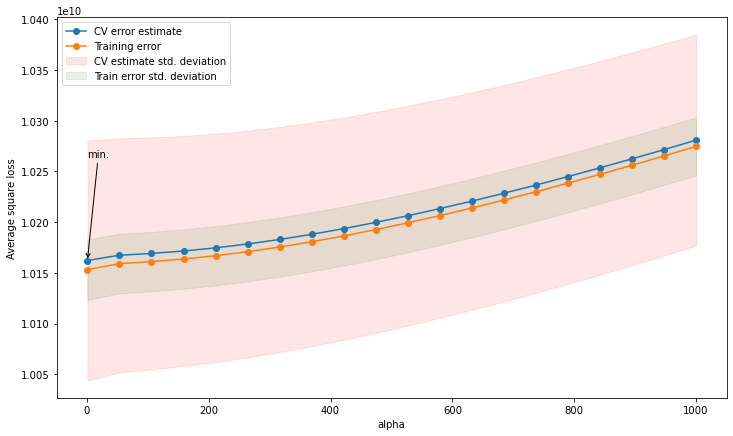

{'Best Hyperparameter': 1.0, 'Cross-Validation Risk Estimate': '1.01621547050334e+10'}


In [46]:
# Validation Curve for unit-length scaled Features

valc_len = ValidationCurve(X, Y, 'unit_length', True)
train_cv_len, val_cv_len = valc_len.val_curve_ridge(np.linspace(1, 1000, 20), 5, 100)

---

## Dimensionality Reduction Method: Principal Component Analysis

In [47]:
# Principal Component Analysis (PCA) algorithm

class PCA() : 
      
    # Create the PCA() object
    def __init__(self, scaled_features) : 
        
        self.scaled_features = scaled_features
        
          
    # Perform Singolar Value Decomposition on the Features matrix
    def singular_values(self):
        
        U, SIGMA, V_T = LA.svd(self.scaled_features, full_matrices = False)
        
        # Save the Sigma matrix for the projection of the Features in a lower dimensional space
        self.V_T = V_T
        
        return(U, SIGMA, V_T)
    
    
    # Compute the Cumulative Percentage of Variance Explained by the Principal Components
    def variance_explained(self, SIGMA_mat):
        
        # Track the sum of the percentage of Variance Explained
        percentages = np.zeros((len(SIGMA_mat), 1))
        
        for i in range(0, len(SIGMA_mat)):
            percentages[i] = SIGMA_mat[i]/np.sum(SIGMA_mat)
        
        # Display the corresponding Screeplot
        plt.figure(figsize=(12,7))
        plt.plot(range(1,len(SIGMA_mat)+1), percentages, marker='o')
        plt.xlabel('Singular Values')
        plt.ylabel('Explained variance')
        plt.title('Total variance explained for each principal component')
        plt.show()
        
        self.percentages = percentages
        
        return(percentages)
    
    
    # Project the Features according to the selected number of Principal Components
    def projected_features(self, n_components, show_plot = False):
        
        proj_feat = np.transpose(self.V_T[:, :n_components].T @ self.scaled_features.T)
        
        col_names = np.repeat("DIM {}", n_components)
        
        for o in range(0, n_components):
            col_names[o] = col_names[o].format(o+1)
            
        self.n_components = n_components
        proj_feat.columns = col_names
        
        
        # Display the Projected Features in a two-dimensional subspace
        if n_components == 2 and show_plot == True:
            
            plt.figure(figsize=(12,7))
            plt.scatter(proj_feat.iloc[:, 0], proj_feat.iloc[:, 1])
            plt.xlabel('First principal component')
            plt.ylabel('Second principal component')
            plt.title('PCA - California housing features')
            plt.show()
        
        return(proj_feat)
               
    
    # Project the Test Features according to the selected number of Principal Components
    def project_test(self, scaled_test_features):
        
        pca_test = PCA(scaled_test_features)
        pca_test_u, pca_test_sigma, pca_test_vt = pca_test.singular_values()
        pca_test_proj = pca_test.projected_features(self.n_components)
        
        return(pca_test_proj)

### Select the Principal Components from the Screeplot

The array that would be returned with the Screeplot corresponds to the percentage of *Variance Explained* by each Principal Component.

#### NO Scaling

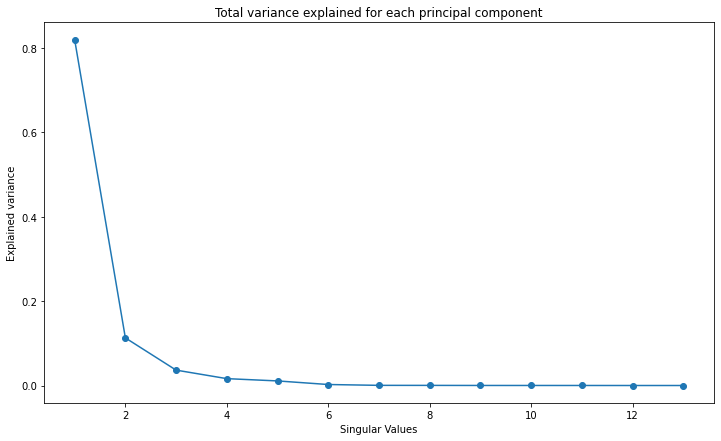

array([[0.8202402 ],
       [0.1129122 ],
       [0.03648223],
       [0.0162808 ],
       [0.01085425],
       [0.00233751],
       [0.00036296],
       [0.00027516],
       [0.00010345],
       [0.00008369],
       [0.00006339],
       [0.00000365],
       [0.00000051]])

In [48]:
# PCA and Screeplot for non-scaled Features

## Apply PCA

pca = PCA(X)
u, sig, vt = pca.singular_values()

## Display the Screeplot

pca.variance_explained(sig)

#### Standardization

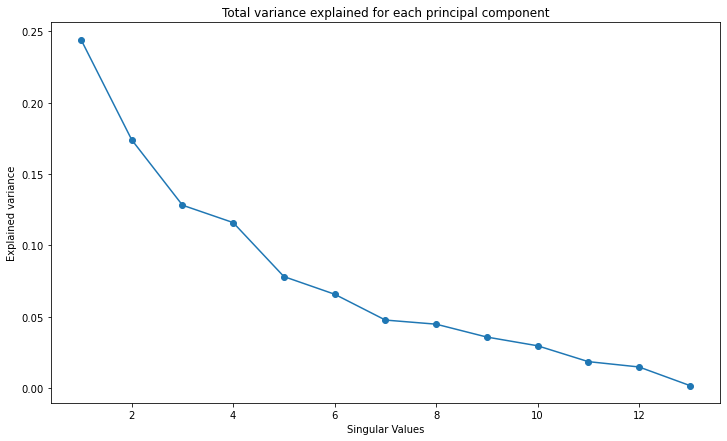

array([[0.24414388],
       [0.17393771],
       [0.12819199],
       [0.11598842],
       [0.07819281],
       [0.0658427 ],
       [0.04775108],
       [0.04486949],
       [0.03585201],
       [0.02974831],
       [0.01864523],
       [0.01490721],
       [0.00192915]])

In [49]:
# PCA and Screeplot for standardized Features

## Scale the Features

standar = features_transformation(scale_transform = 'standardization')
X_std = standar.fit(X)

## Apply PCA

pca_std = PCA(X_std)
u_std, sig_std, vt_std = pca_std.singular_values()

## Display the Screeplot
pca_std.variance_explained(sig_std)

#### Normalization

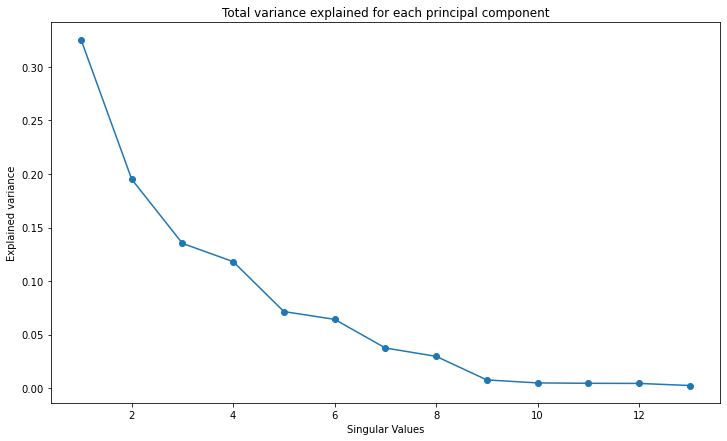

array([[0.32559323],
       [0.19502875],
       [0.1351395 ],
       [0.11809041],
       [0.07144609],
       [0.06416541],
       [0.03742346],
       [0.02961922],
       [0.00759219],
       [0.00478586],
       [0.00443024],
       [0.00431551],
       [0.00237013]])

In [50]:
# PCA and Screeplot for normalized Features

## Scale the Features

normal = features_transformation(scale_transform = 'normalization')
X_norm = normal.fit(X)

## Apply PCA

pca_norm = PCA(X_norm)
u_norm, sig_norm, vt_norm = pca_norm.singular_values()

## Display the Screeplot

pca_norm.variance_explained(sig_norm)

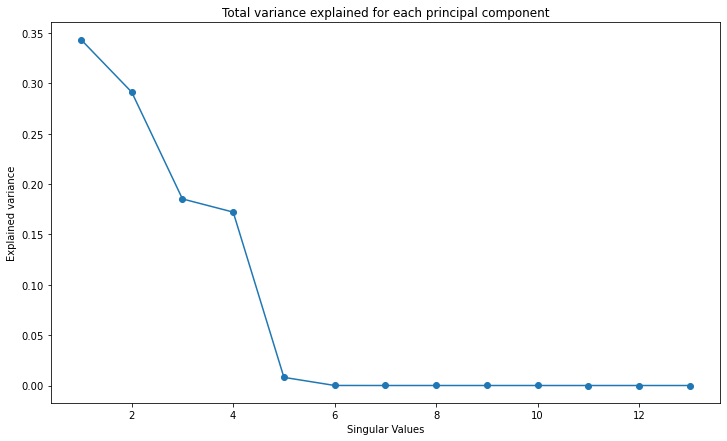

array([[0.34336525],
       [0.29116509],
       [0.18519488],
       [0.17211916],
       [0.00807795],
       [0.00003891],
       [0.00001303],
       [0.00000948],
       [0.00000763],
       [0.00000484],
       [0.00000241],
       [0.00000127],
       [0.0000001 ]])

In [51]:
# PCA and Screeplot for unit-length scaled Features

## Scale the Features

unit_len = features_transformation(scale_transform = 'unit_length')
X_len = unit_len.fit(X)

## Apply PCA

pca_len = PCA(X_len)
u_len, sig_len, vt_len = pca_len.singular_values()

# Display the Screeplot

pca_len.variance_explained(sig_len)

### Project the Features into a two-dimensional space

The DataFrame that would be returned with the two-dimensional plot corresponds to the new coordinates of the data points, according to the first two Principal Components.

#### NO Scaling

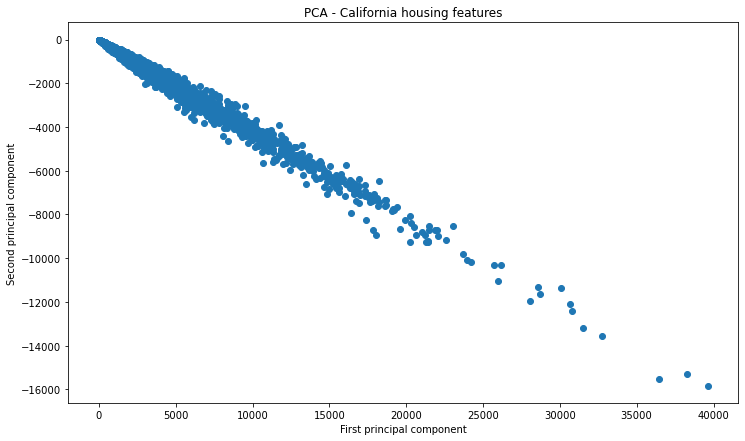

,DIM 1,DIM 2
0,871.807360,-359.460140
1,6982.735607,-2922.715767
2,1449.776499,-569.721246
3,1284.875141,-548.982336
4,1606.667137,-672.127387
...,...,...
20428,1704.398897,-752.593205
20429,715.663734,-300.406262
20430,2273.947040,-997.251310
20431,1855.478832,-810.120424


In [52]:
pca.projected_features(2, True)

#### Standardization

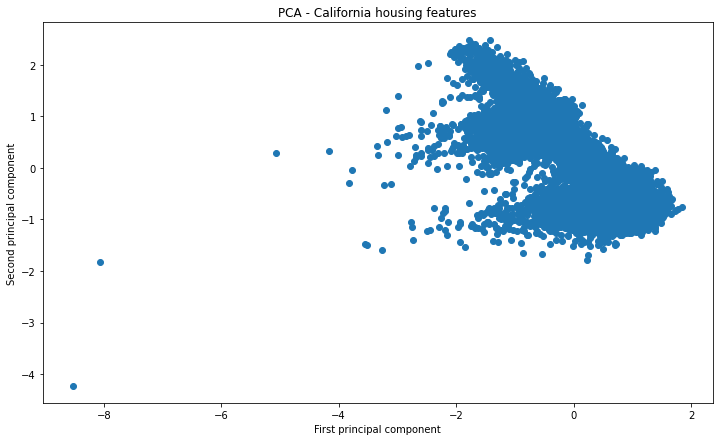

,DIM 1,DIM 2
0,-0.789763,0.723989
1,-1.271039,0.597294
2,-0.801756,0.817888
3,-0.704568,0.927601
4,-0.547356,1.079918
...,...,...
20428,-0.873898,1.544934
20429,-0.751480,1.497352
20430,-0.876119,1.506326
20431,-0.820004,1.523253


In [53]:
pca_std.projected_features(2, True)

#### Normalization

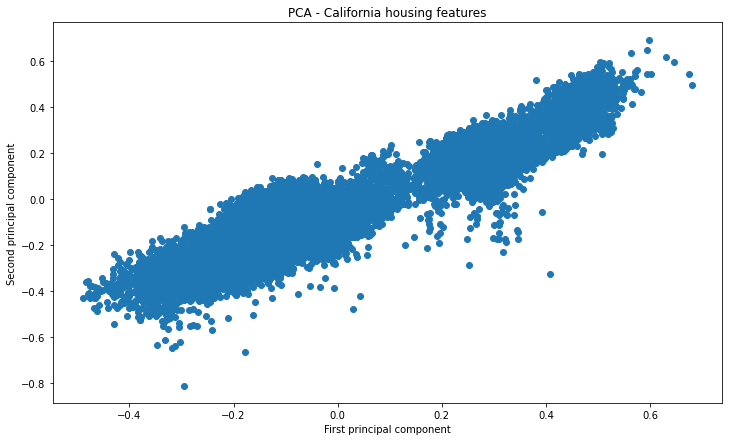

,DIM 1,DIM 2
0,0.041798,-0.018710
1,-0.011880,-0.047473
2,0.041985,-0.076427
3,0.016825,-0.107581
4,-0.016066,-0.137501
...,...,...
20428,-0.162127,-0.077110
20429,-0.153147,-0.010293
20430,-0.168903,-0.056617
20431,-0.157956,-0.045976


In [54]:
pca_norm.projected_features(2, True)

#### Unit-length Scaling

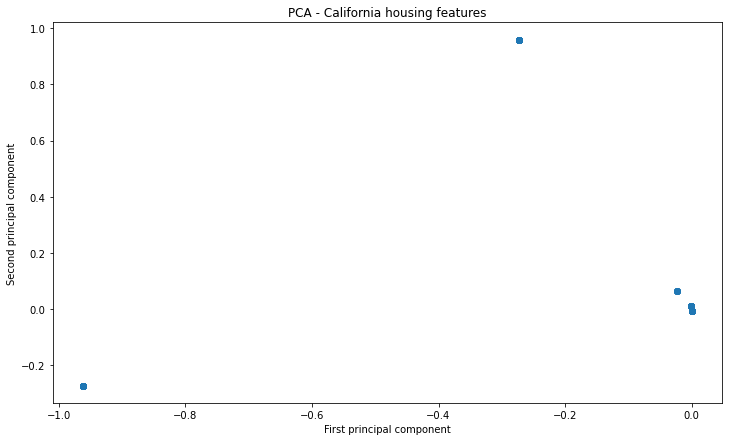

,DIM 1,DIM 2
0,-0.272218,0.959771
1,-0.272218,0.959772
2,-0.272218,0.959771
3,-0.272218,0.959771
4,-0.272218,0.959772
...,...,...
20428,0.000189,-0.009070
20429,0.000189,-0.009070
20430,0.000189,-0.009070
20431,0.000189,-0.009070


In [55]:
pca_len.projected_features(2, True)

### Principal Component Validation Curve

Select the optimal number of Principal Components with respect to the corresponding *Risk Estimate*.

#### NO Scaling

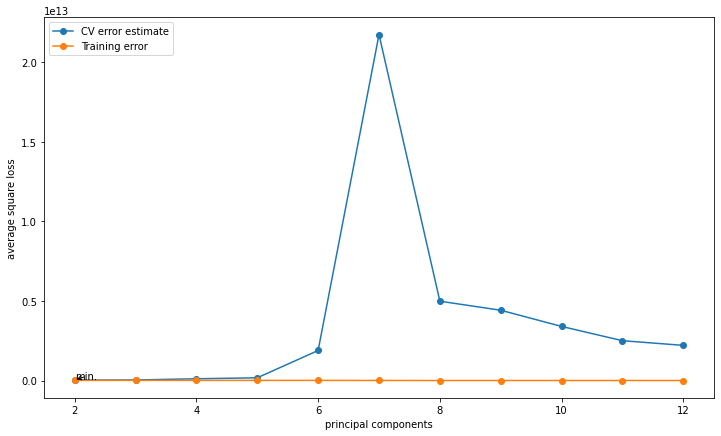

{'Best Number of Principal Components': 2, 'Cross-Validation Risk Estimate': '2.9185653607710197e+10'}


In [56]:
# Recall the previous "ValidationCurve" for non-scaled Features

train_pcacv, val_pcacv = valc.val_curve_pca(np.arange(2,13), 5, 100)

#### Standardization

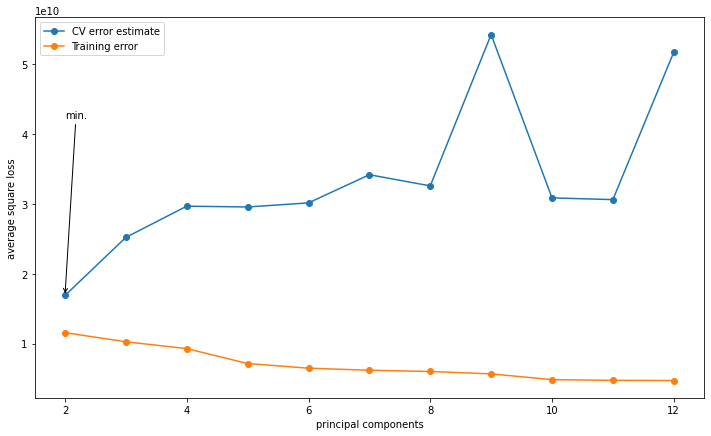

{'Best Number of Principal Components': 2, 'Cross-Validation Risk Estimate': '1.6885792147551199e+10'}


In [57]:
# Recall the previous "ValidationCurve" for the standardized Features

train_pcacv_std, val_pcacv_std = valc_std.val_curve_pca(np.arange(2,13), 5, 100)

#### Normalization

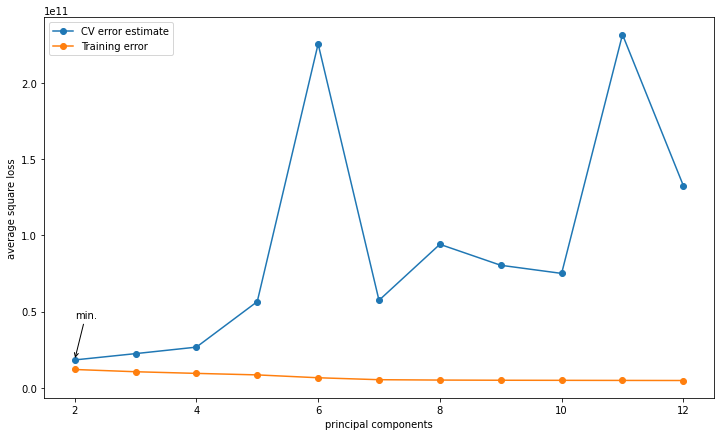

{'Best Number of Principal Components': 2, 'Cross-Validation Risk Estimate': '1.82386407235966e+10'}


In [58]:
# Recall the previous "ValidationCurve" for normalized Features

train_pcacv_norm, val_pcacv_norm = valc_norm.val_curve_pca(np.arange(2,13), 5, 100)

#### Unit-length Scaling

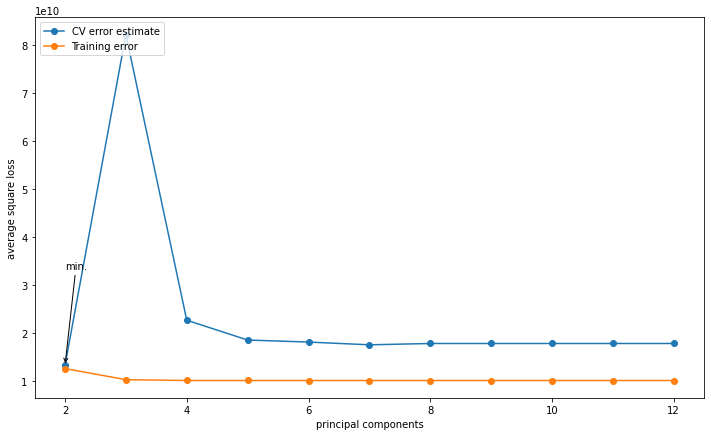

{'Best Number of Principal Components': 2, 'Cross-Validation Risk Estimate': '1.3305684349950602e+10'}


In [59]:
# Recall the previous "ValidationCurve" for unit-length scaled Features

train_pcacv_len, val_pcacv_len = valc_len.val_curve_pca(np.arange(2,13), 5, 100)

---

## Hyperparameter Tuning with Nested Cross-Validation

The estimate of the running time of the `nested_cv()` function for each transformation method is indicate below the code.

In [60]:
def nested_cv(features, labels, f_scaling, grid_alpha, k_inner, k_outer, seed, include_intercept = True):
    
    # Arrays for tracking outer Training, Validation errors e the best Hyperparametrs tuned in the inner loop
    outval_errors = np.zeros((1, k_outer))
    innval_errors = np.zeros((len(grid_alpha), k_inner))
    bestinn_alphas = np.zeros((1, k_outer))
    
    # Random shuffle of the Features and Labels
    idx_nested = np.random.RandomState(seed = seed).permutation(len(features))
    feat_shuff, labl_shuff = features.loc[idx_nested, :], labels.loc[idx_nested, :]
    
    # Features and Labels divided in "k_outer" number of folds
    feat_out_folds, labl_out_folds = np.array_split(feat_shuff, k_outer), np.array_split(labl_shuff, k_outer)
    
    # Loop on the outer Training and Validation Folds
    for i in range(0, k_outer):
        
        # Features and Labels in the outer Validation fold at each iteration
        outf_val = feat_out_folds[i]
        outl_val = labl_out_folds[i]
        
        # Features and Labels in the outer Training folds at each iteration
        outf_train = feat_shuff.drop(outf_val.index)
        outl_train = labl_shuff.drop(outl_val.index)
        
        # Training Features and Labels divided in "k_inner" number of folds
        feat_inn_folds, labl_inn_folds = np.array_split(outf_train, k_inner), np.array_split(outl_train, k_inner)
        
        # Loop on the values of the Hyperparameter in the grid 
        for alp in range(0, len(grid_alpha)):
            
            # Loop on the inner Training and Validation folds
            for inn in range(0, k_inner):
                
                # Features and Labels in the inner Validation fold at each iteration
                innf_val = feat_inn_folds[inn]
                innl_val = labl_inn_folds[inn]
                
                # Features and Labels in the inner Training folds at each iteration
                innf_train = outf_train.drop(innf_val.index)
                innl_train = outl_train.drop(innl_val.index)
                
                # Transform the Features without breaking the independence between Training and Validation inner folds
                if f_scaling is not None:
                    transformer = features_transformation(scale_transform = f_scaling)
                    innf_train = transformer.fit(innf_train)
                    innf_val = transformer.test_transform(innf_val)
                
                # Train the predictor on the inner Training folds
                ridge_nested = Ridge(alpha = grid_alpha[alp], intercept = include_intercept)
                ridge_nested.fit(innf_train, innl_train)     
                
                # Compute the inner Validation Error according to the square loss
                innval_pred = ridge_nested.predict(innf_val)
                innval_errors[alp, inn] = np.mean((innval_pred - innl_val)**2)
        
        # Retrieve the best Hyperparameter from the inner loop according to the corresponding inner Validation Error
        innval_mean = np.mean(innval_errors, axis = 1)
        bestinn_alphas[0,i] = grid_alpha[np.where(innval_mean == np.min(innval_mean))]
        
        # Transform the Features without breaking the independence between Training and Validation outer folds
        if f_scaling is not None:
            transformer = features_transformation(scale_transform = f_scaling)
            outf_train = transformer.fit(outf_train)
            outf_val = transformer.test_transform(outf_val)
        
        # Train the predictor with the best Hyperparameter on the outer Training folds
        ridge_outer = Ridge(alpha = bestinn_alphas[0,i], intercept = include_intercept)
        ridge_outer.fit(outf_train, outl_train)
        
        # Compute the outer Validation Error according to the square loss        
        outval_pred = ridge_outer.predict(outf_val)
        outval_errors[0, i] = np.mean((outval_pred - outl_val)**2)
            
    # Compute the average of the Outer Validation Errors as an estimate for the risk
    nestedcv_score = np.mean(outval_errors)
    print("Nested CV risk estimate is: ")
        
    return(np.format_float_scientific(nestedcv_score))

### Nested Cross-Validation

Inner number of folds: $k' = 3$.

Outer number of folds: $k = 5$.

#### NO Scaling

In [61]:
nested_cv(X, Y, None, np.linspace(1, 5000, 20), 3, 5, 100)

Nested CV risk estimate is: 


'4.732981086448187e+09'

2.86 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#### Standardization

In [62]:
nested_cv(X, Y, 'standardization', np.linspace(1, 5000, 20), 3, 5, 100)

Nested CV risk estimate is: 


'4.732955016777669e+09'

2.91 s ± 226 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#### Normalization

In [63]:
nested_cv(X, Y, 'normalization', np.linspace(1, 5000, 20), 3, 5, 100)

Nested CV risk estimate is: 


'4.760656225798572e+09'

3.43 s ± 236 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#### Unit-length Scaling

In [64]:
nested_cv(X, Y, 'unit_length', np.linspace(1, 5000, 20), 3, 5, 100)

Nested CV risk estimate is: 


'1.0162154705033722e+10'

2.17 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---